In [ ]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohith1245673184674","key":"aac38bc450c02d395a614c324c2a5c9e"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:05<00:00, 178MB/s]
100% 812M/812M [00:05<00:00, 150MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

Copying images to training, validation, and test directories

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

Training the convent network from scratch
Model 1:Training sample of 1000, a validation sample of 500, and a test sample of 500

In [ ]:
make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

Instantiating a small convnet for dogs vs. cats classification

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Configuring the model for training

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


Data preprocessing

Using image_dataset_from_directory to read images

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shapes of the data and labels yielded by the Dataset



In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using a Dataset

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 26ms/step - loss: 0.7131 - accuracy: 0.4990 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.5185 - val_loss: 0.6911 - val_accuracy: 0.5570
Epoch 3/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6818 - accuracy: 0.6015 - val_loss: 0.6846 - val_accuracy: 0.5850
Epoch 4/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6515 - accuracy: 0.6145 - val_loss: 0.6431 - val_accuracy: 0.6190
Epoch 5/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6221 - accuracy: 0.6645 - val_loss: 0.6260 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6104 - accuracy: 0.6865 - val_loss: 0.6218 - val_accuracy: 0.6470
Epoch 7/30
63/63 [==============================] - 1s 15ms/step - loss: 0.5819 - accuracy: 0.7130 - val_loss: 0.6338 - val_accuracy: 0.6590
Epoch 8/30
6

Displaying curves of loss and accuracy during training



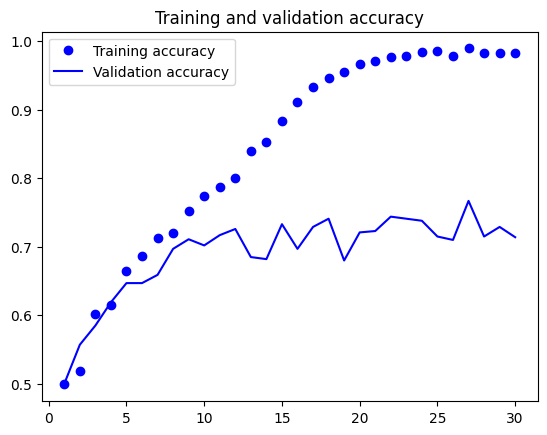

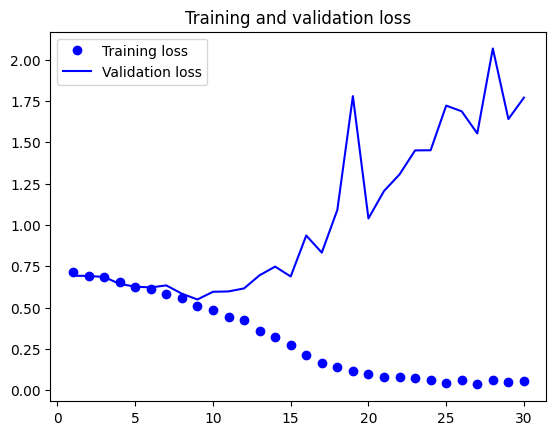

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set



In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.5393 - accuracy: 0.7390
Test accuracy: 0.739


Since the validation and the tes accuracy of the model is very low that is 75%

To improve performance in developing a network that we trained from scratch, we will train our model on following techniques.

Model 2: Using Data Augmentation

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
     callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 4s 20ms/step - loss: 0.6986 - accuracy: 0.5120 - val_loss: 0.6920 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.7035 - accuracy: 0.5485 - val_loss: 0.6914 - val_accuracy: 0.5020
Epoch 3/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6864 - accuracy: 0.5595 - val_loss: 0.6929 - val_accuracy: 0.5050
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6861 - accuracy: 0.5605 - val_loss: 0.6580 - val_accuracy: 0.6300
Epoch 5/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6628 - accuracy: 0.6110 - val_loss: 0.6915 - val_accuracy: 0.5660
Epoch 6/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6501 - accuracy: 0.6145 - val_loss: 0.6366 - val_accuracy: 0.6700
Epoch 7/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6340 - accuracy: 0.6390 - val_loss: 0.6490 - val_accuracy: 0.6340
Epoch 8/30
63

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.4609 - accuracy: 0.7890
Test accuracy: 0.789


Defining a data augmentation stage to add to an image model



In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images



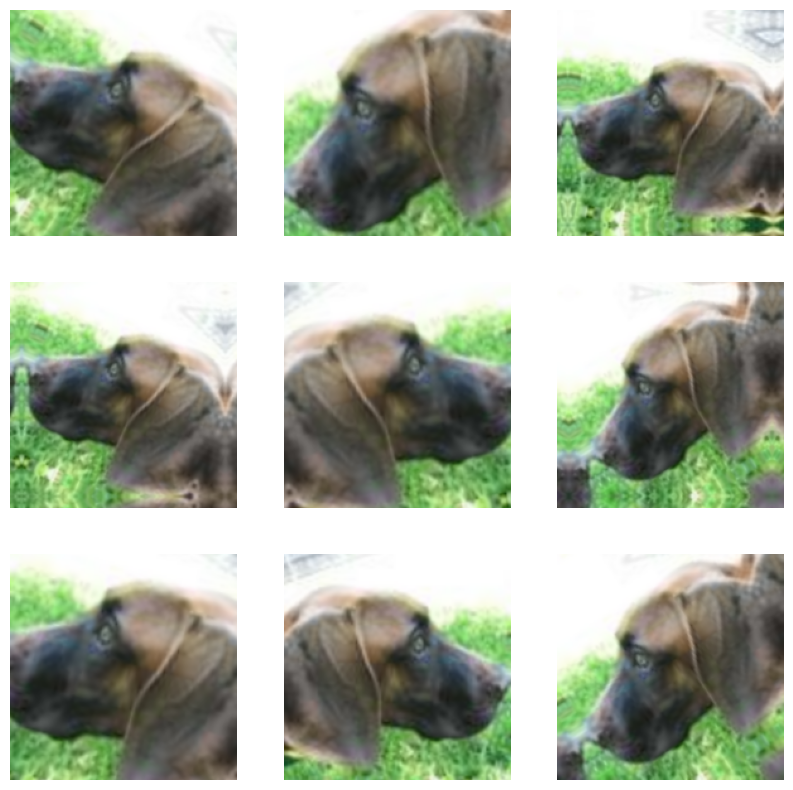

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Model 3: Using Dropout Method

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 3s 18ms/step - loss: 0.6982 - accuracy: 0.5145 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6953 - accuracy: 0.5215 - val_loss: 0.6876 - val_accuracy: 0.5850
Epoch 3/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6800 - accuracy: 0.5965 - val_loss: 0.6580 - val_accuracy: 0.6230
Epoch 4/30
63/63 [==============================] - 1s 15ms/step - loss: 0.6490 - accuracy: 0.6460 - val_loss: 0.6738 - val_accuracy: 0.5570
Epoch 5/30
63/63 [==============================] - 1s 15ms/step - loss: 0.6134 - accuracy: 0.6580 - val_loss: 1.1216 - val_accuracy: 0.5380
Epoch 6/30
63/63 [==============================] - 1s 16ms/step - loss: 0.6100 - accuracy: 0.6830 - val_loss: 0.5930 - val_accuracy: 0.6840
Epoch 7/30
63/63 [==============================] - 1s 16ms/step - loss: 0.5749 - accuracy: 0.7175 - val_loss: 0.5964 - val_accuracy: 0.6650
Epoch 8/30
63

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.5062 - accuracy: 0.7620
Test accuracy: 0.762


Model 4: Using both Image Augmentation and Dropout mthod



In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 3s 20ms/step - loss: 0.6954 - accuracy: 0.5270 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6925 - accuracy: 0.5375 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6857 - accuracy: 0.5760 - val_loss: 0.6585 - val_accuracy: 0.6250
Epoch 4/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6707 - accuracy: 0.6125 - val_loss: 0.6665 - val_accuracy: 0.5990
Epoch 5/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6529 - accuracy: 0.6430 - val_loss: 0.6479 - val_accuracy: 0.6350
Epoch 6/30
63/63 [==============================] - 1s 17ms/step - loss: 0.6262 - accuracy: 0.6645 - val_loss: 0.6194 - val_accuracy: 0.6670
Epoch 7/30
63/63 [==============================] - 1s 18ms/step - loss: 0.6192 - accuracy: 0.6575 - val_loss: 0.6038 - val_accuracy: 0.6890
Epoch 8/30
63

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.4237 - accuracy: 0.7980
Test accuracy: 0.798


after training the model using the above three techniques we can see that the model trained using both data augmentation and drop out method gave relatively improved accuracy, hence we will be using this technique .

As we know Training with more data helps to increase accoracy of mode as it avoids the overfitting problem. We will be increasing the training sample size further.



Model 5) Increasing the Training sample size to 5000.Including Maxpooling,Data Augmentation and Dropout technique with dropout rate of 0.5



In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_1", start_index=0, end_index=5000)
make_subset("validation_1", start_index=5000, end_index=5500)
make_subset("test_1", start_index=5500, end_index=6000)

train_dataset_1 = image_dataset_from_directory(
    new_base_dir / "train_1",
    image_size=(180, 180),
    batch_size=32)
validation_dataset_1 = image_dataset_from_directory(
    new_base_dir / "validation_1",
    image_size=(180, 180),
    batch_size=32)
test_dataset_1 = image_dataset_from_directory(
    new_base_dir / "test_1",
    image_size=(180, 180),
    batch_size=32)


Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Defining a new convnet that includes image augmentation and dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers

# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

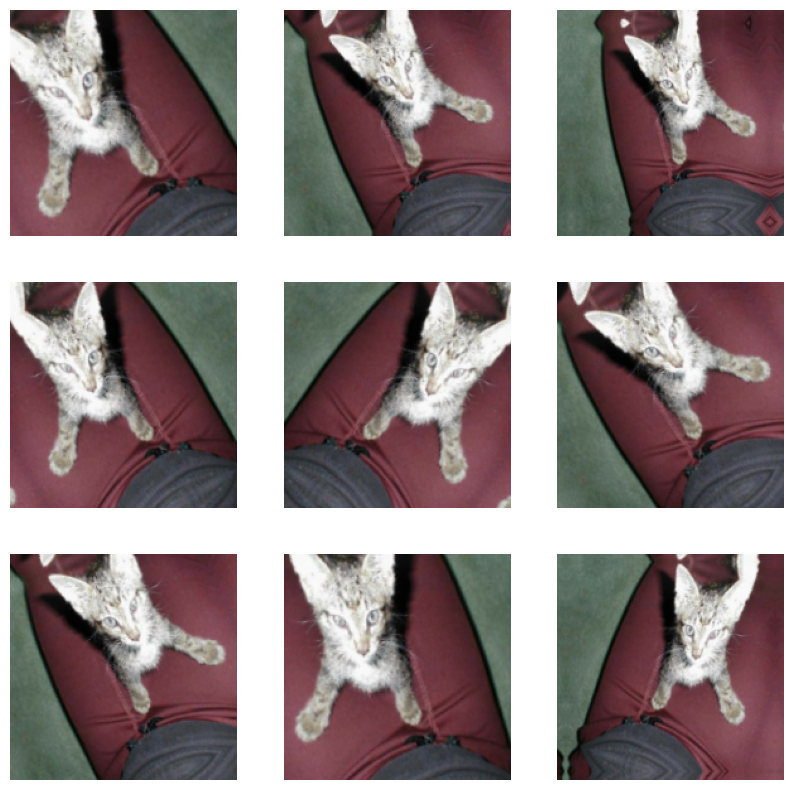

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset_1,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
313/313 [==============================] - 6s 12ms/step - loss: 0.6847 - accuracy: 0.5454 - val_loss: 0.6633 - val_accuracy: 0.6010
Epoch 2/30
313/313 [==============================] - 4s 12ms/step - loss: 0.6102 - accuracy: 0.6691 - val_loss: 0.7131 - val_accuracy: 0.5930
Epoch 3/30
313/313 [==============================] - 4s 12ms/step - loss: 0.5539 - accuracy: 0.7203 - val_loss: 0.4837 - val_accuracy: 0.7640
Epoch 4/30
313/313 [==============================] - 4s 12ms/step - loss: 0.4627 - accuracy: 0.7839 - val_loss: 0.4640 - val_accuracy: 0.7960
Epoch 5/30
313/313 [==============================] - 4s 12ms/step - loss: 0.4035 - accuracy: 0.8155 - val_loss: 0.3066 - val_accuracy: 0.8800
Epoch 6/30
313/313 [==============================] - 4s 12ms/step - loss: 0.3475 - accuracy: 0.8504 - val_loss: 0.2830 - val_accuracy: 0.9010
Epoch 7/30
313/313 [==============================] - 4s 12ms/step - loss: 0.3014 - accuracy: 0.8723 - val_loss: 0.2658 - val_accuracy: 0.8830

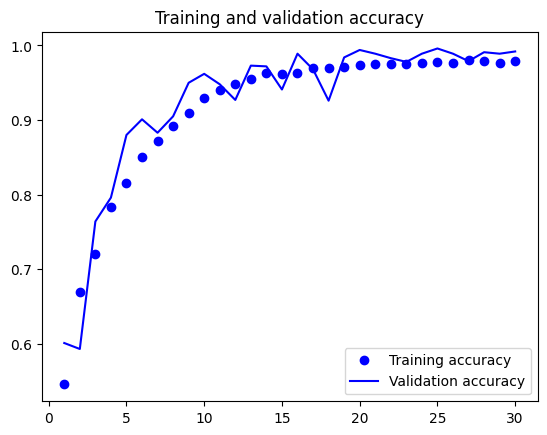

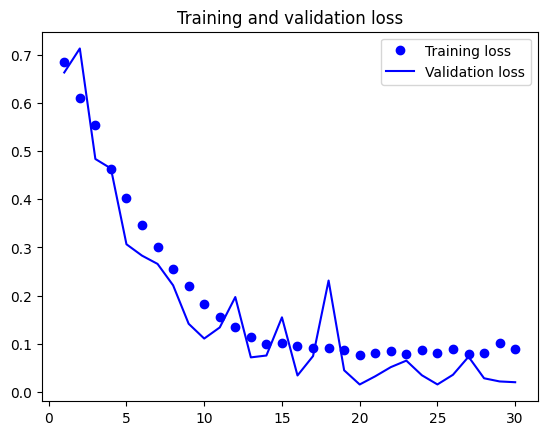

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.5153 - accuracy: 0.8890
Test accuracy: 0.889


Model 6: Increasing the Training sample size to 10000

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_4", start_index=0, end_index=10000)
make_subset("validation_4", start_index=10000, end_index=10500)
make_subset("test_4", start_index=10500, end_index=11000)

train_dataset_4 = image_dataset_from_directory(
    new_base_dir / "train_4",
    image_size=(180, 180),
    batch_size=32)
validation_dataset_4 = image_dataset_from_directory(
    new_base_dir / "validation_4",
    image_size=(180, 180),
    batch_size=32)
test_dataset_4 = image_dataset_from_directory(
    new_base_dir / "test_4",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


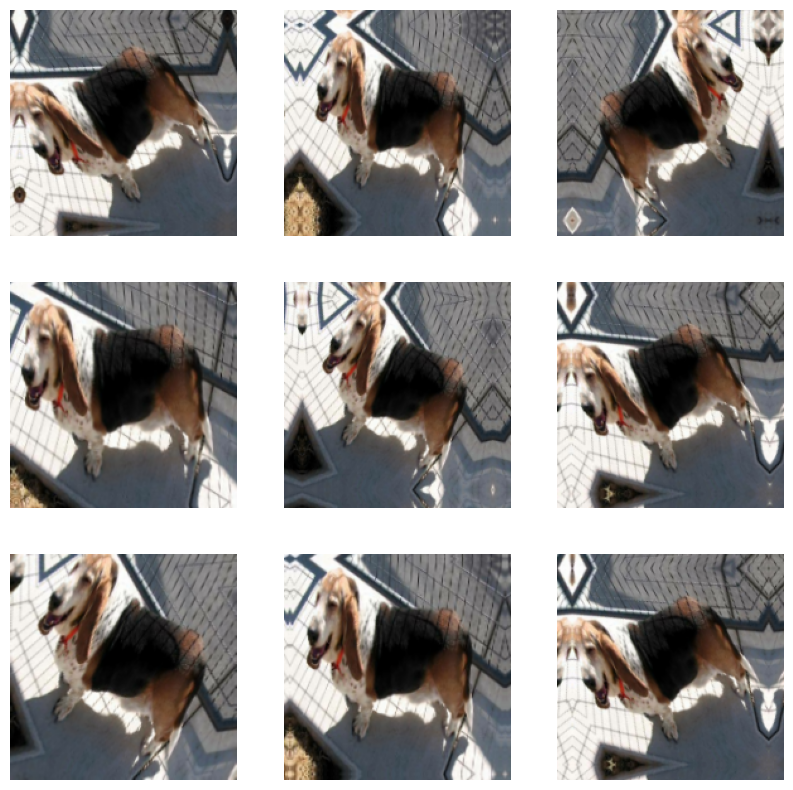

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset_4,
    epochs=30,
    validation_data=validation_dataset_4,
    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 9s 12ms/step - loss: 0.6561 - accuracy: 0.6047 - val_loss: 0.5742 - val_accuracy: 0.7000
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 0.5360 - accuracy: 0.7311 - val_loss: 0.4753 - val_accuracy: 0.7740
Epoch 3/30
625/625 [==============================] - 7s 11ms/step - loss: 0.4283 - accuracy: 0.8048 - val_loss: 0.3392 - val_accuracy: 0.8580
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - loss: 0.3455 - accuracy: 0.8482 - val_loss: 0.3486 - val_accuracy: 0.8480
Epoch 5/30
625/625 [==============================] - 7s 11ms/step - loss: 0.2897 - accuracy: 0.8759 - val_loss: 0.2829 - val_accuracy: 0.8740
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - loss: 0.2418 - accuracy: 0.8995 - val_loss: 0.2801 - val_accuracy: 0.8890
Epoch 7/30
625/625 [==============================] - 7s 11ms/step - loss: 0.2016 - accuracy: 0.9164 - val_loss: 0.2720 - val_accuracy: 0.8970

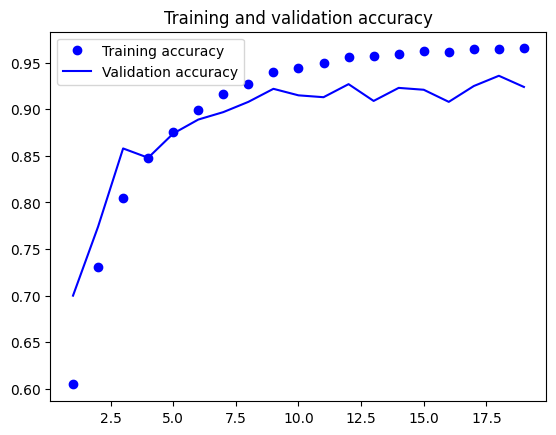

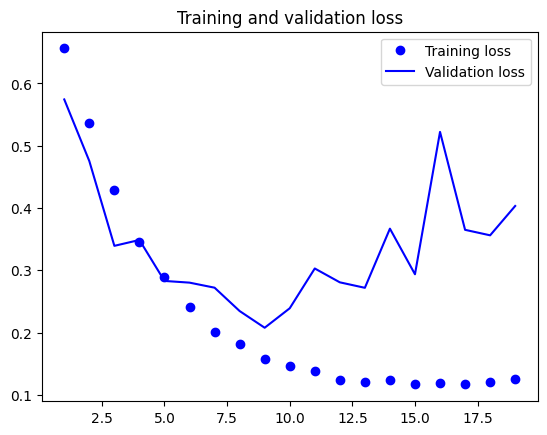

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset_4)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 0s 7ms/step - loss: 0.3039 - accuracy: 0.9020
Test accuracy: 0.902


Feature extraction together with data augmentation

Instantiating and freezing the VGG16 convolutional base

Model 7: Pre-Trained Model - 1000 Training samples

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


Adding a data augmentation stage and a classifier to the convolutional base

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 45ms/step - loss: 3.3211 - accuracy: 0.7635 - val_loss: 0.7387 - val_accuracy: 0.9220
Epoch 2/30
63/63 [==============================] - 2s 31ms/step - loss: 0.9502 - accuracy: 0.8750 - val_loss: 0.4234 - val_accuracy: 0.9390
Epoch 3/30
63/63 [==============================] - 2s 31ms/step - loss: 0.5595 - accuracy: 0.9140 - val_loss: 0.3231 - val_accuracy: 0.9520
Epoch 4/30
63/63 [==============================] - 2s 31ms/step - loss: 0.3805 - accuracy: 0.9305 - val_loss: 0.2473 - val_accuracy: 0.9600
Epoch 5/30
63/63 [==============================] - 2s 27ms/step - loss: 0.2903 - accuracy: 0.9335 - val_loss: 0.2516 - val_accuracy: 0.9580
Epoch 6/30
63/63 [==============================] - 2s 30ms/step - loss: 0.2100 - accuracy: 0.9460 - val_loss: 0.2396 - val_accuracy: 0.9620
Epoch 7/30
63/63 [==============================] - 2s 31ms/step - loss: 0.1781 - accuracy: 0.9590 - val_loss: 0.2011 - val_accuracy: 0.9600
Epoch 8/30
63

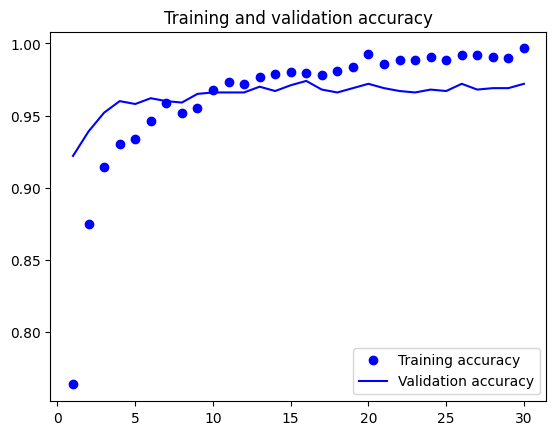

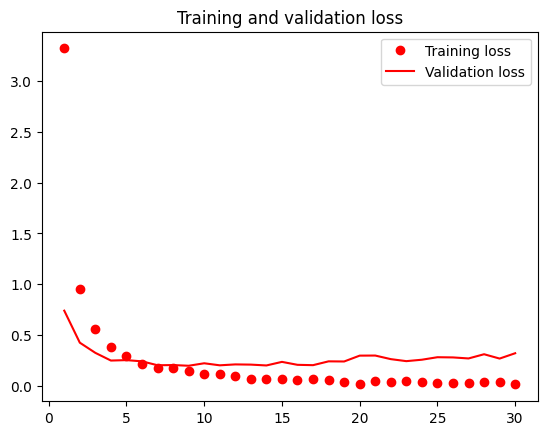

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 16ms/step - loss: 0.1578 - accuracy: 0.9750
Test accuracy: 0.975


Model 8: Pre-Trained Model - 5000 Training samples

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_1,
    epochs=10,
    validation_data=validation_dataset_1,
    callbacks=callbacks)

Epoch 1/10
313/313 [==============================] - 9s 21ms/step - loss: 1.3932 - accuracy: 0.8612 - val_loss: 0.1851 - val_accuracy: 0.9590
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 0.2066 - accuracy: 0.9339 - val_loss: 0.1165 - val_accuracy: 0.9700
Epoch 3/10
313/313 [==============================] - 6s 20ms/step - loss: 0.1459 - accuracy: 0.9510 - val_loss: 0.0996 - val_accuracy: 0.9760
Epoch 4/10
313/313 [==============================] - 6s 19ms/step - loss: 0.1171 - accuracy: 0.9594 - val_loss: 0.1035 - val_accuracy: 0.9750
Epoch 5/10
313/313 [==============================] - 6s 19ms/step - loss: 0.1084 - accuracy: 0.9627 - val_loss: 0.1321 - val_accuracy: 0.9770
Epoch 6/10
313/313 [==============================] - 6s 19ms/step - loss: 0.0878 - accuracy: 0.9709 - val_loss: 0.1274 - val_accuracy: 0.9760
Epoch 7/10
313/313 [==============================] - 6s 20ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.1212 - val_accuracy: 0.9780

In [ ]:
model = keras.models.load_model("fine_tuning2.keras")
test_loss, test_acc = model.evaluate(test_dataset_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 16ms/step - loss: 0.1063 - accuracy: 0.9760
Test accuracy: 0.976


Model 9: Pre-Trained Model - 10000 samples

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_4,
    epochs=10,
    validation_data=validation_dataset_4,
    callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 14s 19ms/step - loss: 0.7498 - accuracy: 0.8941 - val_loss: 0.1497 - val_accuracy: 0.9650
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1396 - accuracy: 0.9506 - val_loss: 0.1542 - val_accuracy: 0.9620
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1161 - accuracy: 0.9609 - val_loss: 0.0991 - val_accuracy: 0.9800
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0998 - accuracy: 0.9665 - val_loss: 0.1547 - val_accuracy: 0.9750
Epoch 5/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0895 - accuracy: 0.9715 - val_loss: 0.1580 - val_accuracy: 0.9770
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0867 - accuracy: 0.9726 - val_loss: 0.1581 - val_accuracy: 0.9750
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0835 - accuracy: 0.9735 - val_loss: 0.1742 - val_accuracy:

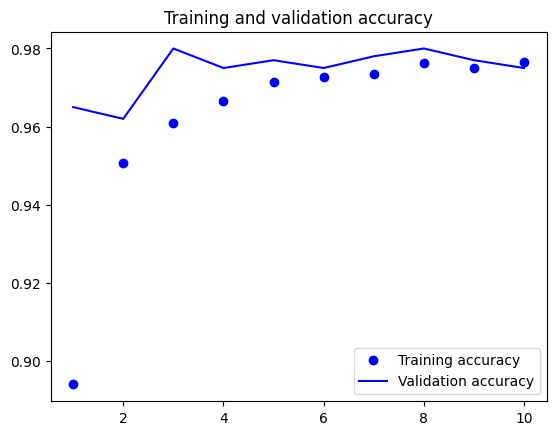

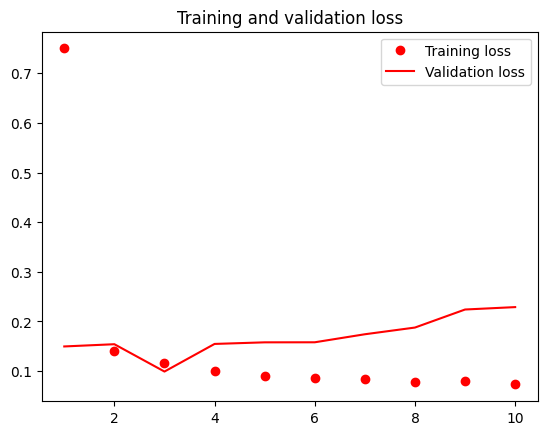

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning3.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 16ms/step - loss: 0.0779 - accuracy: 0.9830
Test accuracy: 0.983
